# Leveraging EPA to predict game outcomes compared to lines set by Sportsbook

Citations:
- Dominguez (2021, Feb. 4). Open Source Football: Modeling NFL game outcomes using Python and scikit-learn. Retrieved from https://mrcaseb.github.io/open-source-football/posts/2021-01-21-nfl-game-prediction-using-logistic-regression/
- https://github.com/nflverse/nfldata/blob/master/DATASETS.md#games

In [3]:
import pandas as pd
import numpy as np

In [5]:
# import all of our play_by_play data
data = pd.read_csv('play_by_play.csv')

def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[:i+1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]
            
    return pd.Series(values, index=x.index)

# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = data.loc[data['rush_attempt'] == 1, :]\
.groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

rushing_defense_epa = data.loc[data['rush_attempt'] == 1, :]\
.groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_offense_epa = data.loc[data['pass_attempt'] == 1, :]\
.groupby(['posteam', 'season', 'week'], as_index=False)['epa'].mean()

passing_defense_epa = data.loc[data['pass_attempt'] == 1, :]\
.groupby(['defteam', 'season', 'week'], as_index=False)['epa'].mean()

# lag EPA one period back to give us EPA going INTO a game.
rushing_offense_epa['epa_shifted'] = rushing_offense_epa.groupby('posteam')['epa'].shift()
rushing_defense_epa['epa_shifted'] = rushing_defense_epa.groupby('defteam')['epa'].shift()
passing_offense_epa['epa_shifted'] = passing_offense_epa.groupby('posteam')['epa'].shift()
passing_defense_epa['epa_shifted'] = passing_defense_epa.groupby('defteam')['epa'].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column 
# However we will use a dynamic window for the model

rushing_offense_epa['ewma'] = rushing_offense_epa.groupby('posteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_offense_epa['ewma_dynamic_window'] = rushing_offense_epa.groupby('posteam')\
.apply(dynamic_window_ewma).values

rushing_defense_epa['ewma'] = rushing_defense_epa.groupby('defteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_defense_epa['ewma_dynamic_window'] = rushing_defense_epa.groupby('defteam')\
.apply(dynamic_window_ewma).values

passing_offense_epa['ewma'] = passing_offense_epa.groupby('posteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_offense_epa['ewma_dynamic_window'] = passing_offense_epa.groupby('posteam')\
.apply(dynamic_window_ewma).values

passing_defense_epa['ewma'] = passing_defense_epa.groupby('defteam')['epa_shifted']\
.transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_defense_epa['ewma_dynamic_window'] = passing_defense_epa.groupby('defteam')\
.apply(dynamic_window_ewma).values

#Merge all the data together
offense_epa = rushing_offense_epa.merge(passing_offense_epa, on=['posteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
.rename(columns={'posteam': 'team'})
defense_epa = rushing_defense_epa.merge(passing_defense_epa, on=['defteam', 'season', 'week'], suffixes=('_rushing', '_passing'))\
.rename(columns={'defteam': 'team'})
epa = offense_epa.merge(defense_epa, on=['team', 'season', 'week'], suffixes=('_offense', '_defense'))

#remove the first season of data because we are doing EWMA
epa = epa.loc[epa['season'] != epa['season'].unique()[0], :]

epa = epa.reset_index(drop=True)

epa.head()

c:\users\joebu\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3524: DtypeWarning: Columns (37,38,46,180,181,183,184,190,191,194,195,198,199,204,205,206,207,208,209,210,211,212,213,214,215,219,220,221,223,225,227,234,235,236,237,238,239,249,250,254,255,256,261,263,264,267,268,269,270,284,285,293,294,295,296,297,300,302,303,304) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,team,season,week,epa_rushing_offense,epa_shifted_rushing_offense,ewma_rushing_offense,ewma_dynamic_window_rushing_offense,epa_passing_offense,epa_shifted_passing_offense,ewma_passing_offense,ewma_dynamic_window_passing_offense,epa_rushing_defense,epa_shifted_rushing_defense,ewma_rushing_defense,ewma_dynamic_window_rushing_defense,epa_passing_defense,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,ARI,2000,1,-0.345669,-0.068545,-0.109518,-0.109518,0.019830,0.056256,-0.172588,-0.172588,0.166199,0.363190,0.086016,0.086016,-0.009200,0.269840,0.115978,0.115978
1,ARI,2000,2,-0.276743,-0.345669,-0.153920,-0.153920,0.558977,0.019830,-0.136410,-0.136410,-0.065981,0.166199,0.101092,0.101092,0.283460,-0.009200,0.092441,0.092441
2,ARI,2000,4,-0.334533,-0.276743,-0.176871,-0.176871,-0.264054,0.558977,-0.006468,-0.006468,-0.018524,-0.065981,0.069872,0.069872,0.500345,0.283460,0.128136,0.128136
3,ARI,2000,5,-0.016838,-0.334533,-0.206184,-0.206184,0.049141,-0.264054,-0.054359,-0.054359,0.004625,-0.018524,0.053437,0.053437,0.058499,0.500345,0.197339,0.197339
4,ARI,2000,6,-0.038473,-0.016838,-0.171124,-0.171124,0.101830,0.049141,-0.035195,-0.035195,0.086308,0.004625,0.044399,0.044399,-0.063633,0.058499,0.171631,0.171631


In [9]:
epa['team'].unique()

array(['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL',
       'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV',
       'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF',
       'TB', 'TEN', 'WAS'], dtype=object)

In [5]:
game_data = pd.read_csv('games_data.csv')

In [6]:
print(game_data.info())
game_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6137 entries, 0 to 6136
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        6137 non-null   int64  
 1   game_id           6137 non-null   object 
 2   season            6137 non-null   int64  
 3   game_type         6137 non-null   object 
 4   week              6137 non-null   int64  
 5   gameday           6137 non-null   object 
 6   weekday           6137 non-null   object 
 7   gametime          5878 non-null   object 
 8   away_team         6137 non-null   object 
 9   away_score        6137 non-null   int64  
 10  home_team         6137 non-null   object 
 11  home_score        6137 non-null   int64  
 12  location          6137 non-null   object 
 13  result            6137 non-null   int64  
 14  total             6137 non-null   int64  
 15  overtime          6137 non-null   int64  
 16  old_game_id       6137 non-null   int64  


,Unnamed: 0,game_id,season,game_type,week,gameday,weekday,gametime,away_team,away_score,...,wind,away_qb_id,home_qb_id,away_qb_name,home_qb_name,away_coach,home_coach,referee,stadium_id,stadium
0,0,1999_01_MIN_ATL,1999,REG,1,1999-09-12,Sunday,NaN,MIN,17,...,NaN,00-0003761,00-0002876,Randall Cunningham,Chris Chandler,Dennis Green,Dan Reeves,Gerry Austin,ATL00,Georgia Dome
1,1,1999_01_KC_CHI,1999,REG,1,1999-09-12,Sunday,NaN,KC,17,...,12.0,00-0006300,00-0010560,Elvis Grbac,Shane Matthews,Gunther Cunningham,Dick Jauron,Phil Luckett,CHI98,Soldier Field
2,2,1999_01_PIT_CLE,1999,REG,1,1999-09-12,Sunday,NaN,PIT,43,...,12.0,00-0015700,00-0004230,Kordell Stewart,Ty Detmer,Bill Cowher,Chris Palmer,Bob McElwee,CLE00,Cleveland Browns Stadium
3,3,1999_01_OAK_GB,1999,REG,1,1999-09-12,Sunday,NaN,OAK,24,...,10.0,00-0005741,00-0005106,Rich Gannon,Brett Favre,Jon Gruden,Ray Rhodes,Tony Corrente,GNB00,Lambeau Field
4,4,1999_01_BUF_IND,1999,REG,1,1999-09-12,Sunday,NaN,BUF,14,...,NaN,00-0005363,00-0010346,Doug Flutie,Peyton Manning,Wade Phillips,Jim Mora,Ron Blum,IND99,RCA Dome


In [7]:
df = game_data.merge(epa.rename(columns={'team': 'home_team'}), on=['home_team', 'season', 'week'])\
.merge(epa.rename(columns={'team': 'away_team'}), on=['away_team', 'season', 'week'], suffixes=('_home', '_away'))
print(df.info())
df.head()

NameError: name 'epa' is not defined

In [8]:
df.to_csv('nfl_mdf.csv')

NameError: name 'df' is not defined

In [5]:
# Read in the .csv for future runs, so we don't have to rebuild
df = pd.read_csv('nfl_mdf.csv')

## Creating flags for outcomes and preparing dataframe for modeling

### Important data points:
- spread_line: The spread line for the game. A positive number means the home team was favored by that many points, a negative number means the away team was favored by that many points. This lines up with the result column.
- result: The number of points the home team scored minus the number of points the visiting team scored. Equals h_score - v_score. Is NA for games which haven't yet been played. Convenient for evaluating against the spread bets.

In [6]:
def game_results(row):
    if row['away_score'] - row['home_score'] > 0:
        row['home_team_win'] = 0
    else:
        row['home_team_win'] = 1
    if row['total'] > row['total_line']:
        row['over_hit'] = 1
    if row['total'] == row['total_line']:
        # Here 99 will indicate a push
        row['over_hit'] = 99
    else:
        row['over_hit'] = 0
    if row['result'] > row['spread_line']:
        row['home_spread_hit'] = 1
    if row['result'] == row['spread_line']:
        # Here 99 will indicate a push
        row['home_spread_hit'] = 99
    if row['result'] < row['spread_line']:
        row['home_spread_hit'] = 0
    return row

In [7]:
cols_list = ['away_score', 'home_score', 'total', 'total_line', 'result', 'spread_line']
df_test = df[cols_list].head(50)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   away_score   50 non-null     int64  
 1   home_score   50 non-null     int64  
 2   total        50 non-null     int64  
 3   total_line   50 non-null     float64
 4   result       50 non-null     int64  
 5   spread_line  50 non-null     float64
dtypes: float64(2), int64(4)
memory usage: 2.5 KB


In [8]:
# Let's run our function against a test dataset and make sure by digging into individual cases that it is working correctly
df_test_r = df_test.apply(game_results, axis=1)
df_test_r

,away_score,home_score,total,total_line,result,spread_line,home_team_win,over_hit,home_spread_hit
0,28.0,36.0,64.0,46.5,8.0,6.5,1.0,0.0,1.0
1,27.0,7.0,34.0,38.5,-20.0,-10.5,0.0,0.0,0.0
2,27.0,14.0,41.0,44.0,-13.0,-3.5,0.0,0.0,0.0
3,27.0,30.0,57.0,46.5,3.0,4.5,1.0,0.0,0.0
4,21.0,16.0,37.0,36.0,-5.0,-3.0,0.0,0.0,0.0
5,14.0,10.0,24.0,40.5,-4.0,0.0,0.0,0.0,0.0
6,16.0,21.0,37.0,40.0,5.0,6.5,1.0,0.0,0.0
7,16.0,0.0,16.0,37.0,-16.0,-2.5,0.0,0.0,0.0
8,17.0,20.0,37.0,47.5,3.0,10.5,1.0,0.0,0.0
9,41.0,14.0,55.0,39.5,-27.0,6.0,0.0,0.0,0.0


## Building final dataframe:
Now that we have seen that our flags are functioning correctly, we will function against our main dataframe, and trim it down to our 

In [9]:
df = df.apply(game_results, axis=1)
cols_list = ['game_id', 'away_score', 'home_score', 'total', 'total_line', 'result', 'spread_line',\
             'ewma_dynamic_window_rushing_offense_home', 'ewma_dynamic_window_passing_offense_home', \
            'ewma_dynamic_window_rushing_defense_home', 'ewma_dynamic_window_passing_defense_home', \
            'ewma_dynamic_window_rushing_offense_away', 'ewma_dynamic_window_passing_offense_away', \
            'ewma_dynamic_window_rushing_defense_away', 'ewma_dynamic_window_passing_defense_away',
            'home_spread_hit', 'over_hit', 'home_team_win'] 
df = df[cols_list]
print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5047 entries, 0 to 5046
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   game_id                                   5047 non-null   object 
 1   away_score                                5047 non-null   int64  
 2   home_score                                5047 non-null   int64  
 3   total                                     5047 non-null   int64  
 4   total_line                                5047 non-null   float64
 5   result                                    5047 non-null   int64  
 6   spread_line                               5047 non-null   float64
 7   ewma_dynamic_window_rushing_offense_home  5046 non-null   float64
 8   ewma_dynamic_window_passing_offense_home  5046 non-null   float64
 9   ewma_dynamic_window_rushing_defense_home  5046 non-null   float64
 10  ewma_dynamic_window_passing_defense_

,game_id,away_score,home_score,total,total_line,result,spread_line,ewma_dynamic_window_rushing_offense_home,ewma_dynamic_window_passing_offense_home,ewma_dynamic_window_rushing_defense_home,ewma_dynamic_window_passing_defense_home,ewma_dynamic_window_rushing_offense_away,ewma_dynamic_window_passing_offense_away,ewma_dynamic_window_rushing_defense_away,ewma_dynamic_window_passing_defense_away,home_spread_hit,over_hit,home_team_win
0,2000_01_SF_ATL,28,36,64,46.5,8,6.5,-0.215767,0.088063,0.011924,0.090955,0.040545,0.085402,-0.101883,0.260712,1,0,1
1,2000_01_JAX_CLE,27,7,34,38.5,-20,-10.5,-0.097135,-0.011817,0.063478,0.152305,-0.000865,0.102550,-0.208297,-0.147295,0,0,0
2,2000_01_IND_KC,27,14,41,44.0,-13,-3.5,-0.058464,0.048722,-0.161479,-0.085959,-0.109888,0.055958,-0.049084,0.092024,0,0,0
3,2000_01_CHI_MIN,27,30,57,46.5,3,4.5,-0.066504,0.162777,-0.231106,0.132783,-0.187493,-0.079538,-0.057451,0.105317,0,0,1
4,2000_01_TB_NE,21,16,37,36.0,-5,-3.0,-0.197793,-0.239533,-0.159227,-0.061119,-0.237161,-0.130162,-0.195255,-0.222231,0,0,0


In [14]:
df.to_csv('NFL_results_ewma.csv')

# Building the Models

## Linear Regression: Total Score

In [10]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sma
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# We need to drop rows with null values. for some reason one game has an ewma that is null.
df = df.dropna()

# One of the interesting things about this model is that we will need to take our test set, and merge all of our
# predictions back to it. Thus we will split the entire df into x_test_cum, and then index the columns we need for each
# individual model later on.
X = df
y = df[['total','result','home_team_win']]

# splitting the data
x_train_cum, x_test_cum, y_train_cum, y_test_cum = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
y_train = y_train_cum['total']
y_test = y_test_cum['total']
x_train = x_train_cum.iloc[:,7:15]
x_test = x_test_cum.iloc[:,7:15]

# creating an object of LinearRegression class
lm = LinearRegression()

# fitting the training data
lm.fit(x_train,y_train)

y_prediction =  lm.predict(x_test)

# predicting the accuracy score
score=r2_score(y_test,y_prediction)
print(f'r2 score is: {score}')
print(f'Mean Squared Error:{mean_squared_error(y_test,y_prediction)}')
print(f'root mean squared error: {np.sqrt(mean_squared_error(y_test,y_prediction))}')

# joining predictions back to original df
x_test_cum['pred_total'] = y_prediction

r2 score is: 0.07390452198277453
Mean Squared Error:203.70570804371772
root mean squared error: 14.27255085973484


## Linear regression: Result (game spread)

In [12]:
y_train = y_train_cum['result']
y_test = y_test_cum['result']
x_train = x_train_cum.iloc[:,7:15]
x_test = x_test_cum.iloc[:,7:15]

# creating an object of LinearRegression class
lm = LinearRegression()

# fitting the training data
lm.fit(x_train,y_train)

y_prediction =  lm.predict(x_test)

# predicting the accuracy score
score=r2_score(y_test,y_prediction)
print(f'r2 score is: {score}')
print(f'Mean Squared Error:{mean_squared_error(y_test,y_prediction)}')
print(f'root mean squared error: {np.sqrt(mean_squared_error(y_test,y_prediction))}')

# joining predictions back to original df
x_test_cum['pred_result'] = y_prediction

r2 score is: 0.10366981820596355
Mean Squared Error:185.5386992484413
root mean squared error: 13.621259091891664


## Logistic Regression: Game Winner

0.6207920792079208


c:\users\joebu\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


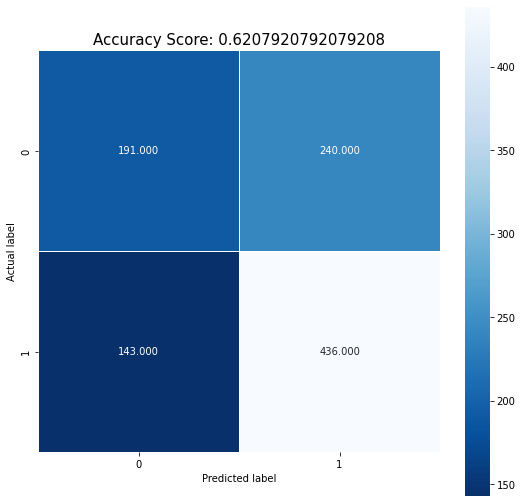

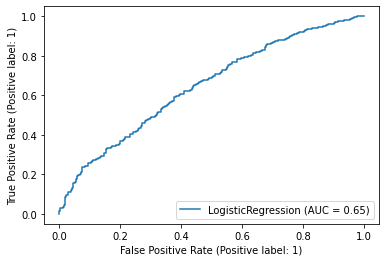

In [13]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

y_train = y_train_cum['home_team_win']
y_test = y_test_cum['home_team_win']
x_train = x_train_cum.iloc[:,7:15]
x_test = x_test_cum.iloc[:,7:15]

# creating an object of LinearRegression class
logisticRegr = LogisticRegression()

# fitting the training data
logisticRegr.fit(x_train, y_train)

y_prediction = logisticRegr.predict(x_test)

# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

cm = metrics.confusion_matrix(y_test, y_prediction)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

metrics.plot_roc_curve(logisticRegr, x_test, y_test) 
plt.show()

# joining predictions back to original df
x_test_cum['pred_hometeam_winner'] = y_prediction

# Results as compared to sports book odds

Here we will take our test values from the data frame and simulate if we placed wagers based upon the regression results, if they would have hit

In [18]:
results_df = x_test_cum
results_df['result'] = results_df['result'].astype('float64')
results_df.head(30)

,game_id,away_score,home_score,total,total_line,result,spread_line,ewma_dynamic_window_rushing_offense_home,ewma_dynamic_window_passing_offense_home,ewma_dynamic_window_rushing_defense_home,...,ewma_dynamic_window_rushing_offense_away,ewma_dynamic_window_passing_offense_away,ewma_dynamic_window_rushing_defense_away,ewma_dynamic_window_passing_defense_away,home_spread_hit,over_hit,home_team_win,pred_total,pred_result,pred_hometeam_winner
4988,2021_16_IND_ARI,22,16,38,48.0,-6.0,3.0,-0.068286,0.086175,-0.098250,...,0.124948,0.012956,-0.047833,-0.066015,0,0,0,44.924442,0.035908,1
3955,2017_16_MIA_KC,13,29,42,43.5,16.0,11.0,0.018464,0.096739,0.012282,...,-0.151600,-0.073872,-0.064338,0.064256,1,0,1,44.828227,7.947621,1
65,2000_06_WAS_PHI,17,14,31,37.5,-3.0,-3.5,-0.073379,-0.063927,-0.148722,...,-0.071773,0.071027,-0.108149,-0.094432,1,0,0,40.764120,1.170957,1
2520,2011_11_CIN_BAL,24,31,55,39.5,7.0,7.0,-0.082930,0.006117,-0.169639,...,-0.118500,0.050439,-0.149700,-0.033619,99,0,1,41.359922,3.538336,1
393,2001_16_KC_JAX,30,26,56,40.0,-4.0,4.5,-0.074807,0.062772,-0.212384,...,0.000649,0.044836,-0.065946,0.120341,0,0,0,44.995152,3.843084,1
179,2000_16_NE_BUF,13,10,23,39.0,-3.0,4.5,-0.098287,-0.088425,-0.110151,...,-0.154040,-0.084240,-0.152434,0.126121,0,0,0,40.247519,4.778126,1
2687,2012_06_IND_NYJ,9,35,44,43.5,26.0,3.5,-0.067884,-0.198631,-0.011350,...,-0.082819,-0.022223,0.023944,0.034594,1,0,1,42.141106,-1.140245,0
1670,2007_13_BUF_WAS,17,16,33,37.0,-1.0,6.5,-0.146640,0.019514,-0.022061,...,-0.088254,-0.116328,-0.053941,0.174978,0,0,0,43.811556,5.410562,1
333,2001_11_SEA_KC,7,19,26,41.0,12.0,1.5,0.022733,-0.108296,-0.057555,...,-0.043932,0.065779,-0.077188,0.168814,1,0,1,45.383727,-0.104937,1
1210,2005_12_BAL_CIN,29,42,71,36.5,13.0,9.0,-0.002883,0.169244,0.044654,...,-0.122932,-0.209858,-0.167416,-0.052241,1,0,1,41.933100,9.500855,1


In [19]:
def bet_results(row):
    # Checking spread bet results
    if row['pred_result'] < row['spread_line'] and row['result'] < row['spread_line']:
        row['spread_hit'] = 1
    elif row['pred_result'] > row['spread_line'] and row['result'] > row['spread_line']:
        row['spread_hit'] = 1
    else:
        row['spread_hit'] = 0
    
    # Checking over/under bet results
    if row['pred_total'] > row['total_line'] and row['total'] > row['total_line']:
        row['over_under_hit'] = 1
    elif row['pred_total'] < row['total_line'] and row['total'] < row['total_line']:
        row['over_under_hit'] = 1
    else:
        row['over_under_hit'] = 0
    return row

In [20]:
results_df = results_df.apply(bet_results, axis=1)
display(results_df.head(15))
print(results_df.info())
results_df.to_csv('results_df.csv')

,game_id,away_score,home_score,total,total_line,result,spread_line,ewma_dynamic_window_rushing_offense_home,ewma_dynamic_window_passing_offense_home,ewma_dynamic_window_rushing_defense_home,...,ewma_dynamic_window_rushing_defense_away,ewma_dynamic_window_passing_defense_away,home_spread_hit,over_hit,home_team_win,pred_total,pred_result,pred_hometeam_winner,spread_hit,over_under_hit
4988,2021_16_IND_ARI,22,16,38,48.0,-6.0,3.0,-0.068286,0.086175,-0.098250,...,-0.047833,-0.066015,0,0,0,44.924442,0.035908,1,1,1
3955,2017_16_MIA_KC,13,29,42,43.5,16.0,11.0,0.018464,0.096739,0.012282,...,-0.064338,0.064256,1,0,1,44.828227,7.947621,1,0,0
65,2000_06_WAS_PHI,17,14,31,37.5,-3.0,-3.5,-0.073379,-0.063927,-0.148722,...,-0.108149,-0.094432,1,0,0,40.764120,1.170957,1,1,0
2520,2011_11_CIN_BAL,24,31,55,39.5,7.0,7.0,-0.082930,0.006117,-0.169639,...,-0.149700,-0.033619,99,0,1,41.359922,3.538336,1,0,1
393,2001_16_KC_JAX,30,26,56,40.0,-4.0,4.5,-0.074807,0.062772,-0.212384,...,-0.065946,0.120341,0,0,0,44.995152,3.843084,1,1,1
179,2000_16_NE_BUF,13,10,23,39.0,-3.0,4.5,-0.098287,-0.088425,-0.110151,...,-0.152434,0.126121,0,0,0,40.247519,4.778126,1,0,0
2687,2012_06_IND_NYJ,9,35,44,43.5,26.0,3.5,-0.067884,-0.198631,-0.011350,...,0.023944,0.034594,1,0,1,42.141106,-1.140245,0,0,0
1670,2007_13_BUF_WAS,17,16,33,37.0,-1.0,6.5,-0.146640,0.019514,-0.022061,...,-0.053941,0.174978,0,0,0,43.811556,5.410562,1,1,0
333,2001_11_SEA_KC,7,19,26,41.0,12.0,1.5,0.022733,-0.108296,-0.057555,...,-0.077188,0.168814,1,0,1,45.383727,-0.104937,1,0,0
1210,2005_12_BAL_CIN,29,42,71,36.5,13.0,9.0,-0.002883,0.169244,0.044654,...,-0.167416,-0.052241,1,0,1,41.933100,9.500855,1,1,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010 entries, 4988 to 1757
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   game_id                                   1010 non-null   object 
 1   away_score                                1010 non-null   int64  
 2   home_score                                1010 non-null   int64  
 3   total                                     1010 non-null   int64  
 4   total_line                                1010 non-null   float64
 5   result                                    1010 non-null   float64
 6   spread_line                               1010 non-null   float64
 7   ewma_dynamic_window_rushing_offense_home  1010 non-null   float64
 8   ewma_dynamic_window_passing_offense_home  1010 non-null   float64
 9   ewma_dynamic_window_rushing_defense_home  1010 non-null   float64
 10  ewma_dynamic_window_passing_defen

In [21]:
spread_accuracy = round(results_df['spread_hit'].mean()*100,1)
over_under_accuracy = round(results_df['over_under_hit'].mean()*100,1)
print(f'The accuracy of the spread model compared to the sportsbook is: {spread_accuracy}%')
print(f'The accuracy of the over/under model compared to the sportsbook is: {over_under_accuracy}%')

The accuracy of the spread model compared to the sportsbook is: 48.0%
The accuracy of the over/under model compared to the sportsbook is: 47.8%


## Implementing a simple confidence mechanic

In [22]:
results_df['spread_diff'] = abs(results_df['result'] - results_df['pred_result'])

# Using 3.5 to represent more than a field goal, and filtering on games with a prediction more than 3.5 points from the line.
results_df_conf = results_df[results_df['spread_diff'] > 3.5]

In [23]:
spread_accuracy = round(results_df_conf['spread_hit'].mean()*100,1)
over_under_accuracy = round(results_df_conf['over_under_hit'].mean()*100,1)
print(f'The accuracy of the spread model compared to the sportsbook is: {spread_accuracy}%')
print(f'The accuracy of the over/under model compared to the sportsbook is: {over_under_accuracy}%')

The accuracy of the spread model compared to the sportsbook is: 40.5%
The accuracy of the over/under model compared to the sportsbook is: 47.9%


# Conclusion:
In conclusion, we can fairly accurately predict the winner of a game. However our accuracy for predicting over/under and spread is worse than flipping a coin. We would consider an accuracy of around 63% (which we see when predicting the moneyline outcome) a success. 

The immediate next steps would be:
- Establish a better measure of confidence than the simple method attempted.
- Consider more features than just EPA.
- We would like to consider only games when there is precipitation. Web scraping for weather data, and train and test only on games where there is precipitation.
    - The hypothesis is that considering the ability of both teams with EPA, we can measure the effect of heavy rainfall on a game. Particularly interesting is to see the affect it has on total game score.
- Attempt additional modeling techniques to see if there is better performance.